<a href="https://colab.research.google.com/github/junhyeong-song/-/blob/main/CoDA_NO_Solving_Shallow_Water_Equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌊 Solving the Shallow Water Equations with **CoDANO** 🚀  

Welcome to this short tutorial! Here, we’ll explore how to leverage the **CoDANO** architecture to solve the **shallow water equations (SWE)** with ease. 🌍⚡  

🎯 And towards the end, we'll explore the highly efficient U-shaped CoDANO architecture for even greater performance! 🔥

## 🔧 Installation  

Before we dive in, let’s install the latest version of the **Neural Operator** library. Follow the steps below to get started! ⬇️  


In [1]:
! git clone https://github.com/neuraloperator/CoDA-NO.git > /dev/null 2>&1
! git clone https://github.com/NeuralOperator/neuraloperator > /dev/null 2>&1
! pip install ./neuraloperator > /dev/null 2>&1
! pip install -r ./neuraloperator/requirements.txt > /dev/null 2>&1

In [2]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.layers.spherical_convolution import SphericalConv
from neuralop.data.datasets import load_spherical_swe
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

In [3]:
import matplotlib.pyplot as plt

## 📊 Generating the Shallow Water Equations (SWE) Dataset 🌊

In [4]:
train_loader, test_loaders = load_spherical_swe(n_train=200, batch_size=64, train_resolution=(32, 64),
                                                test_resolutions=[(32, 64), (64, 128)], n_tests=[50, 50],
                                                test_batch_sizes=[10, 10],)


Loading train dataloader at resolution (32, 64) with 200 samples and batch-size=64
Loading test dataloader at resolution (32, 64) with 50 samples and batch-size=10
Loading test dataloader at resolution (64, 128) with 50 samples and batch-size=10


## 🎨 Visualizing the Data 🌊📊  

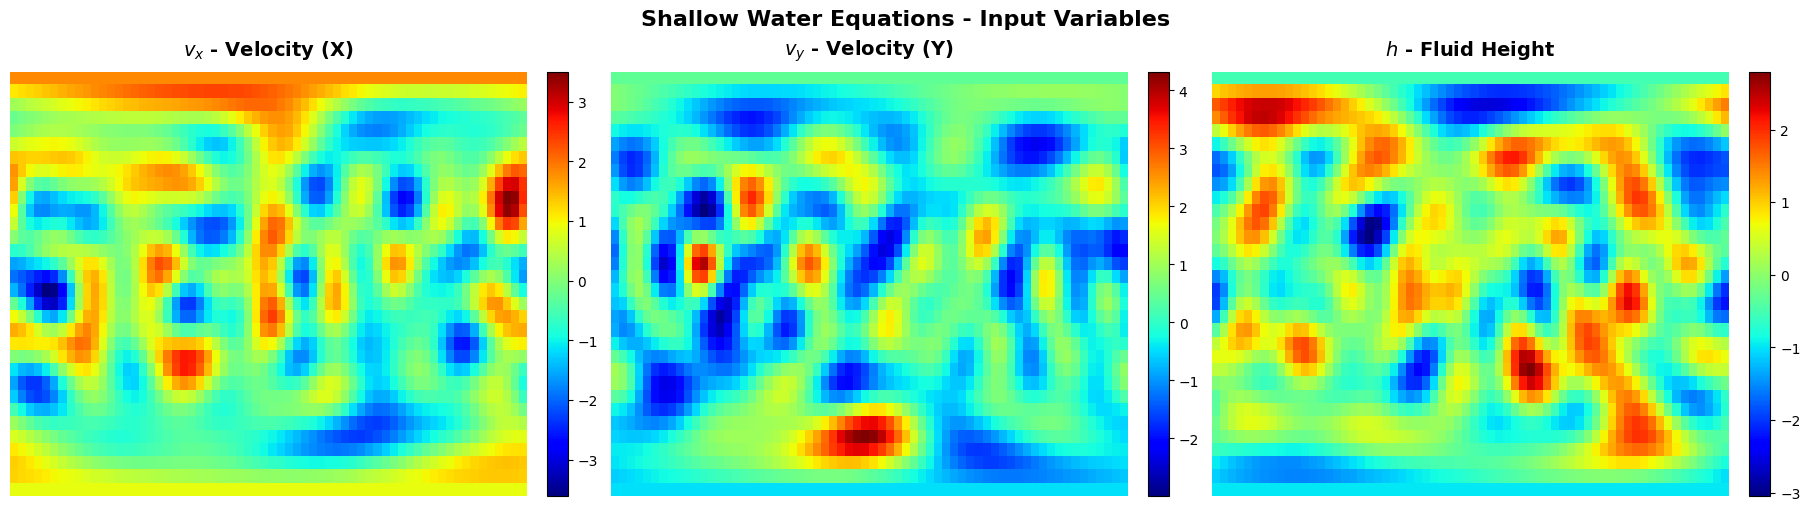

In [6]:
import matplotlib.pyplot as plt
import numpy as np

for data in train_loader:
    x = data['x']
    y = data['y']

    fig, axs = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

    titles = [r'$v_x$ - Velocity (X)', r'$v_y$ - Velocity (Y)', r'$h$ - Fluid Height']
    for i in range(3):
        im = axs[i].imshow(x[0, i, :, :].detach().numpy(), cmap='jet', aspect='auto')
        axs[i].set_title(titles[i], fontsize=14, fontweight='bold', pad=12)
        axs[i].axis('off')  # Remove axis ticks for a cleaner look
        cbar = fig.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04)  # Add colorbar
        cbar.ax.tick_params(labelsize=10)  # Adjust colorbar tick size

    plt.suptitle("Shallow Water Equations - Input Variables", fontsize=16, fontweight='bold')
    plt.show()
    break


## 🚀 Initializing the Model  

The **Codomain Attention Architecture** is a powerful and flexible attention-based model that allows extensive customization for various applications. 🌍✨  

In the following, we begin with a **minimally customized** version of the model to keep things simple while demonstrating its core functionality.  

### 🔍 Key Points to Note:  
1️⃣ **Three Input Variables** → Our model processes **three channels** as input.  
2️⃣ **Spherical Domain** → The function operates on a **sphere**, meaning the input domain has **two spatial dimensions**: **latitude** and **longitude**.  






In [7]:
from neuralop.models.codano import CODANO

# List of input variable names
V_id = ['v_x', 'v_y', 'h']

# Initializing the CoDANO model
model = CODANO(
                1,  # Number of output channels per input variable. Since we have 3 input variables, the total output channels will be 3.

                n_layers=4,  # Number of attention layers in the model.

                n_modes=[[16, 16]] * 4,  # Number of Fourier modes used along each spatial dimension (latitude & longitude). Here, each layer uses 16 modes per dimension.

                n_heads=[1] * 4,  # Number of attention heads per layer. We use 1 head for each of the 4 layers.

                use_positional_encoding=True,  # Enables variable-specific positional encoding.

                positional_encoding_modes=[16, 16],  # Number of Fourier modes used for positional encoding along each input dimension.

                conv_module=SphericalConv,  # Since our problem is defined on a sphere, we use **Spherical Convolution**.

                per_layer_scaling_factors=[[1, 1]] * 4,  # Output scaling factors for each layer along each dimension. To save memory, we could downsample latent functions if needed.

                attention_scaling_factors=[1] * 4,  # Scaling factors for key and query downsampling in the attention mechanism.  Here, no downsampling is applied.

                variable_ids=V_id  # List of variable names (3 variables in this case: v_x, v_y, h).
            )



print token code dimension 1 1
print token code dimension 1 1
print token code dimension 1 1
print token code dimension 1 1


## Generic Training loop

In [8]:
from torch.optim import AdamW
from torch.nn import MSELoss

In [ ]:
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from torch.nn import MSELoss

# Move model to GPU
model = model.cuda()

# Define optimizer (AdamW for better weight decay handling)
optimizer = AdamW(model.parameters(), lr=1e-3)

# Define learning rate scheduler (StepLR reduces LR every few epochs)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Halves LR every 5 epochs

# Define loss function (Mean Squared Error)
loss_fn = MSELoss()

# Number of training epochs
num_epochs = 5000

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = []

    for i, data in enumerate(train_loader):
        x = data['x']
        y = data['y']

        # Move tensors to GPU
        x, y = x.cuda(), y.cuda()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # ⚠️ Note: We must provide `input_variable_ids` to specify variable order.
        # The order in `input_variable_ids` **must match** the channel order in `x`.
        output = model(x, input_variable_ids=V_id)

        # Compute loss
        loss = loss_fn(output, y)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Store loss for monitoring
        total_loss.append(loss.item())

    # Step the learning rate scheduler
    scheduler.step()

    # Print average loss for the epoch
    avg_loss = sum(total_loss) / len(total_loss)
    print(f'🔥 Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.6f} | LR: {scheduler.get_last_lr()[0]:.6f}')


🔥 Epoch 1/5000 | Loss: 2.132335 | LR: 0.001000
🔥 Epoch 2/5000 | Loss: 2.047387 | LR: 0.001000
🔥 Epoch 3/5000 | Loss: 2.075621 | LR: 0.001000
🔥 Epoch 4/5000 | Loss: 2.110073 | LR: 0.001000
🔥 Epoch 5/5000 | Loss: 2.047643 | LR: 0.000500
🔥 Epoch 6/5000 | Loss: 2.033116 | LR: 0.000500
🔥 Epoch 7/5000 | Loss: 2.055187 | LR: 0.000500
🔥 Epoch 8/5000 | Loss: 2.096199 | LR: 0.000500
🔥 Epoch 9/5000 | Loss: 2.031676 | LR: 0.000500
🔥 Epoch 10/5000 | Loss: 1.947680 | LR: 0.000250
🔥 Epoch 11/5000 | Loss: 2.026776 | LR: 0.000250
🔥 Epoch 12/5000 | Loss: 2.019749 | LR: 0.000250
🔥 Epoch 13/5000 | Loss: 2.001953 | LR: 0.000250
🔥 Epoch 14/5000 | Loss: 1.983570 | LR: 0.000250
🔥 Epoch 15/5000 | Loss: 1.961480 | LR: 0.000125
🔥 Epoch 16/5000 | Loss: 2.027852 | LR: 0.000125
🔥 Epoch 17/5000 | Loss: 2.049507 | LR: 0.000125
🔥 Epoch 18/5000 | Loss: 2.036862 | LR: 0.000125
🔥 Epoch 19/5000 | Loss: 1.997217 | LR: 0.000125
🔥 Epoch 20/5000 | Loss: 1.977241 | LR: 0.000063
🔥 Epoch 21/5000 | Loss: 1.988708 | LR: 0.000063
🔥

## 🚀 What if the Fluid Height Variable \( h \) is Missing? 🤯  

In this example, we **push the limits** of our model and show that it can still be trained on the **shallow water equations (SWE)** even when the **fluid height variable \( h \) is missing**.  

🎯 **The best part?** We don’t need to change the architecture at all! **It just works.** ✅  

> Even though we **intentionally discard** the variable here, this isn't just a toy example!  
> 🌍 In real-world applications like **weather modeling**, datasets often have **missing variables** across different sources. Our model can handle such challenges effortlessly.  

⚡ **Let’s dive in and see the magic happen!** ✨🚀🔥  


In [ ]:
for epoch in range(1):
    model.train()
    total_loss = []

    for i, data in enumerate(train_loader):
        x = data['x']
        y = data['y']

        # Move data to GPU
        x, y = x.cuda(), y.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # 📝 Discard the fluid height variable (h)
        x = x[:, :2, :, :]  # Keep only the first two variables (v_x and v_y)
        y = y[:, :2, :, :]  # Same for the target variable (output)

        # Use the same model without any changes
        out = model(x, input_variable_ids=['v_x', 'v_y'])  # Pass only 'v_x' and 'v_y'

        # Compute the loss
        loss = loss_fn(out, y)

        # Backpropagate the loss
        loss.backward()
        optimizer.step()

        # Track the total loss for the epoch
        total_loss.append(loss.item())

    # Print the average loss for the epoch
    avg_loss = sum(total_loss) / len(total_loss)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.6f}')

Epoch 1, Loss: 2.654257


### 🌊🔥 What if a New Variable is Introduced, like Water Temperature \( T \)? 🤯  

In most traditional models, adding a new variable is a challenge. For instance, a CNN trained on RGB images cannot directly handle RGB-D images. But **CoDA-NO** is different! 💡✨  

With **CoDA-NO**, we can seamlessly incorporate the new variable by simply extending the **positional encoding**—no need to retrain the entire model! 🚀  

Let's see it in action! 👇


In [ ]:
model._extend_positional_encoding(['T'])

for epoch in range(1):
    model.train()
    total_loss = []

    for i, data in enumerate(train_loader):
        x = data['x']
        y = data['y']

        # Move data to GPU
        x, y = x.cuda(), y.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # 📝 add new channel "T",
        x = torch.cat((x, torch.zeros_like(x[:, :1, :, :])), dim=1)
        y = torch.cat((y, torch.zeros_like(y[:, :1, :, :])), dim=1)

        # Use the same model without any changes
        out = model(x, input_variable_ids=['v_x', 'v_y', 'h', 'T'])  # codano assumes that the new channel is added at the end.

        # Compute the loss
        loss = loss_fn(out, y)

        # Backpropagate the loss
        loss.backward()
        optimizer.step()

        # Track the total loss for the epoch
        total_loss.append(loss.item())

    # Print the average loss for the epoch
    avg_loss = sum(total_loss) / len(total_loss)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.6f}')

TypeError: 'list' object cannot be interpreted as an integer

# 🌟 Improved U-Shaped Architecture  

In this tutorial, we leverage the **U-shaped architecture** for our model. This design follows the classic encoder-decoder structure with some key improvements:  

1️⃣ **Downscaling and Upscaling**:  
   We begin by downscaling the input data, capturing the most relevant features at lower resolutions. Then, we **upscale** back to the original resolution, allowing the model to reconstruct the output with enhanced details. This process enables more efficient learning of hierarchical features.  

2️⃣ **Horizontal Connections**:  
   To enrich the model's learning capacity, we introduce **horizontal connections** between the encoder and decoder stages. These connections help preserve spatial information and allow the model to capture more complex relationships across different layers.  

By combining these techniques, we can achieve better performance and more accurate reconstructions. 💪💡  

Let's see how these components come together in our architecture! 🚀  


In [ ]:
model = CODANO(1,
                n_layers=5,
                n_modes=[[16, 16]] * 5,
                n_heads=[1] * 5,
                use_positional_encoding=True,
                positional_encoding_modes=[16, 16],
                conv_module=SphericalConv,
                per_layer_scaling_factors=[[1, 1], [0.5,0.5], [1, 1], [2,2,], [1,1]],
                use_horizontal_skip_connection=True,
                horizontal_skips_map= {4:0,3:1},
                attention_scaling_factors=[1] * 5,
                variable_ids=V_id
            )
# Explanation of key components:
# - `per_layer_scaling_factors`: Specifies how the resolution of the feature maps is modified in each layer.
#   - Layer 1 (index 0) downscales by a factor of 2 (scaling factor [0.5, 0.5]).
#   - Layer 3 (index 2) upscales by a factor of 2 (scaling factor [2, 2]).
#   - Other layers retain the resolution (scaling factor [1, 1]).
#
# - `horizontal_skips_map`: Defines horizontal skip connections between layers.
#   - A skip connection is created from layer 0 to layer 4 and from layer 1 to layer 3.
#     This improves information flow across the network, especially when capturing long-range dependencies.

print token code dimension 1 1
print token code dimension 1 1
print token code dimension 1 1
print token code dimension 1 1
print token code dimension 1 1


In [ ]:
model = model.cuda()
optimizer = AdamW(model.parameters(), lr=1e-3)

scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Halves LR every 5 epochs

loss_fn = MSELoss()

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = []

    for i, data in enumerate(train_loader):
        x = data['x']
        y = data['y']
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        output = model(x, input_variable_ids=V_id)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
    scheduler.step()

    avg_loss = sum(total_loss) / len(total_loss)
    print(f'🔥 Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.6f} | LR: {scheduler.get_last_lr()[0]:.6f}')

🔥 Epoch 1/10 | Loss: 2.079702 | LR: 0.001000
🔥 Epoch 2/10 | Loss: 1.919968 | LR: 0.001000
🔥 Epoch 3/10 | Loss: 1.918673 | LR: 0.001000
🔥 Epoch 4/10 | Loss: 1.917291 | LR: 0.001000
🔥 Epoch 5/10 | Loss: 1.890248 | LR: 0.000500
🔥 Epoch 6/10 | Loss: 1.826561 | LR: 0.000500
🔥 Epoch 7/10 | Loss: 1.870951 | LR: 0.000500
🔥 Epoch 8/10 | Loss: 1.858654 | LR: 0.000500
🔥 Epoch 9/10 | Loss: 1.832728 | LR: 0.000500
🔥 Epoch 10/10 | Loss: 1.825671 | LR: 0.000250


# Visualizing Model Outputs

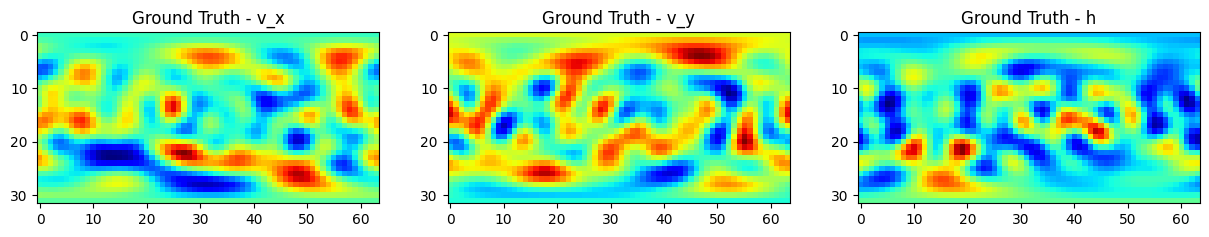

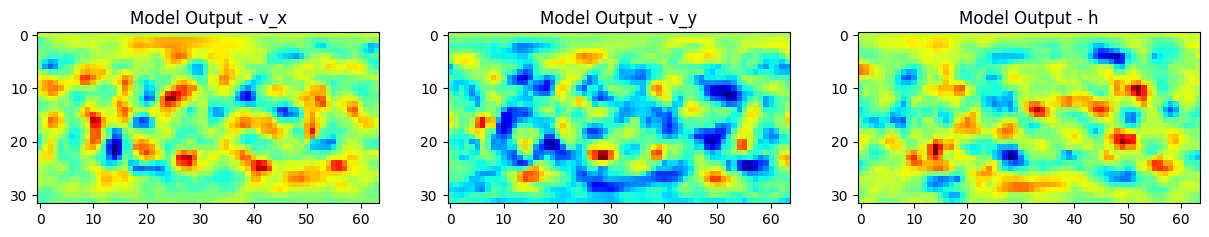

In [ ]:
import matplotlib.pyplot as plt
import torch

# Select a batch from the training data
for i, data in enumerate(train_loader):
    x = data['x']
    y = data['y']

    # Move data to GPU
    x, y = x.cuda(), y.cuda()

    # Get model output
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        output = model(x, input_variable_ids=['v_x', 'v_y', 'h'])

    # Visualize comparison for the first input/output in the batch
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Ground truth visualization
    axs[0].imshow(y[0, 0, :, :].cpu().numpy(), cmap='jet')
    axs[0].set_title('Ground Truth - v_x')
    axs[1].imshow(y[0, 1, :, :].cpu().numpy(), cmap='jet')
    axs[1].set_title('Ground Truth - v_y')
    axs[2].imshow(y[0, 2, :, :].cpu().numpy(), cmap='jet')
    axs[2].set_title('Ground Truth - h')

    # Model output visualization
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(output[0, 0, :, :].cpu().numpy(), cmap='jet')
    axs[0].set_title('Model Output - v_x')
    axs[1].imshow(output[0, 1, :, :].cpu().numpy(), cmap='jet')
    axs[1].set_title('Model Output - v_y')
    axs[2].imshow(output[0, 2, :, :].cpu().numpy(), cmap='jet')
    axs[2].set_title('Model Output - h')

    plt.show()
    break  # Exit after visualizing the first batch
